In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import json
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
from matplotlib import cm
import corner

In [3]:

from agnfinder.tf_sampling.hmc import hmc

Using TensorFlow backend.


In [4]:
tf.enable_eager_execution()

In [5]:
os.chdir('/home/mike/repos/agnfinder')

In [6]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [8]:
# dist = tfd.MultivariateNormalDiag(
#       loc=[.3, .7],
#       scale_diag=[0.3, 0.3])
# dist.mean().numpy()

# two slightly overlapping 2D Gaussians
dist = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=[0.5, 0.5]),
    components_distribution=tfd.MultivariateNormalDiag(
    loc=[[.8, .5], [.2, .5]],
    scale_diag=[[.2, .4], [.2, .4]])
)


Instructions for updating:
The `logits` property will return `None` when the distribution is parameterized with `logits=None`. Use `logits_parameter()` instead.


<tf.Tensor: id=50, shape=(2,), dtype=float32, numpy=array([0.5, 0.5], dtype=float32)>

In [9]:
x = tf.constant(np.random.rand(10, 2), dtype=tf.float32)
print(x.shape)
dist.prob(x).numpy()

(10, 2)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


array([0.84252566, 0.59772056, 0.7849547 , 0.5973316 , 0.6189573 ,
       0.49792728, 0.8185375 , 0.8431659 , 0.56329405, 0.90020716],
      dtype=float32)

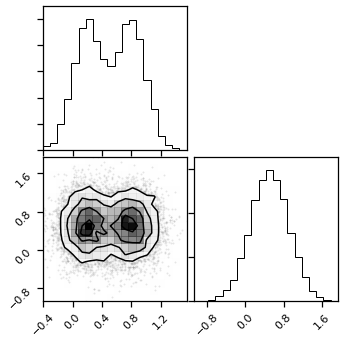

In [11]:
exact_samples = dist.sample(10000)
_ = corner.corner(exact_samples)

In [271]:

log_prob = dist.log_prob
 
n_chains = 30
# initial_state = tf.constant([0.1, 0.15, 0.2])
initial_state = tf.constant(np.random.rand(n_chains, 2), dtype=tf.float32)
num_results = 1000
num_burnin = 100

TensorShape([Dimension(30), Dimension(2)])

In [272]:
log_prob(initial_state).numpy()

array([-0.43500426, -0.7623579 , -0.35189226, -1.0156727 , -0.1744963 ,
       -0.44543022, -1.0144787 , -0.33478403, -0.7990238 , -0.46781504,
       -0.12226421, -0.7816342 , -0.4576442 , -0.23820744, -0.64886105,
       -0.1657799 , -0.57178855, -0.64335066, -0.5258874 , -0.06201103,
       -0.29755306, -0.10945396, -0.38173229, -0.03029505, -0.2152412 ,
       -0.37053418, -0.00421275, -0.33575276, -0.61288273, -0.4631565 ],
      dtype=float32)

In [273]:
step_size = .01
nuts_kernel = tfp.mcmc.NoUTurnSampler(
    target_log_prob_fn=log_prob,
    step_size=step_size
)
# step_size=tf.fill([n_chains, 2], step_size)  # should be same shape as initial_state for each chain to have own step size. Same step size per variable, though??

hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=log_prob,
    num_leapfrog_steps=3,
    step_size=step_size
)

#     step_size=tf.fill([n_chains, 2], step_size)

In [275]:
hmc_adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=hmc_kernel,
    num_adaptation_steps=int(num_burnin * 0.8)
)

# https://github.com/tensorflow/probability/issues/549
nuts_adaptive_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    nuts_kernel,
    num_adaptation_steps=int(num_burnin * 0.8),
    step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(step_size=new_step_size),
    step_size_getter_fn=lambda pkr: pkr.step_size,
    log_accept_prob_getter_fn=lambda pkr: pkr.log_accept_ratio,
)

In [276]:
# initial_state.shape

TensorShape([Dimension(30), Dimension(2)])

In [277]:
%%timeit

chain_output = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin,
    current_state=initial_state,
    kernel=hmc_adaptive_kernel,
    trace_fn=None
)

#     https://github.com/tensorflow/probability/blob/f90448698cc2a16e20939686ef0d5005aad95f29/tensorflow_probability/python/mcmc/nuts.py#L72
#     trace_fn=lambda _, prev_kernel_results: {'is_accepted': prev_kernel_results.inner_results.is_accepted, 'step_size': prev_kernel_results.inner_results.step_size}

In [ ]:
%%timeit

chain_output = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin,
    current_state=initial_state,
    kernel=nuts_adaptive_kernel,
    trace_fn=None
)

In [278]:
type(chain_output)
samples, trace = chain_output
samples = samples.numpy()

In [279]:
# trace['step_size']

In [280]:
is_accepted = trace['is_accepted'].numpy()
step_size = trace['step_size'][0].numpy()

In [281]:
trace['step_size'][0][1]

<tf.Tensor: id=44244374, shape=(30, 2), dtype=float32, numpy=
array([[0.2396061 , 0.2396061 ],
       [0.24714756, 0.24714756],
       [0.26839048, 0.26839048],
       [0.26610398, 0.26610398],
       [0.28809547, 0.28809547],
       [0.2576258 , 0.2576258 ],
       [0.22520259, 0.22520259],
       [0.29653487, 0.29653487],
       [0.21296135, 0.21296135],
       [0.27081802, 0.27081802],
       [0.2758875 , 0.2758875 ],
       [0.24028818, 0.24028818],
       [0.23783666, 0.23783666],
       [0.26960823, 0.26960823],
       [0.24757634, 0.24757634],
       [0.24273063, 0.24273063],
       [0.27644992, 0.27644992],
       [0.2490351 , 0.2490351 ],
       [0.24735713, 0.24735713],
       [0.26628584, 0.26628584],
       [0.2546096 , 0.2546096 ],
       [0.30101767, 0.30101767],
       [0.27687794, 0.27687794],
       [0.25613663, 0.25613663],
       [0.2737583 , 0.2737583 ],
       [0.27379823, 0.27379823],
       [0.2545119 , 0.2545119 ],
       [0.2787452 , 0.2787452 ],
       [0.2685

In [282]:
# is_accepted

In [283]:
is_accepted.mean()

0.9518666666666666

In [284]:
step_size.min(), step_size.max()

(0.21296135, 0.30101767)

In [285]:
samples.shape

(1000, 30, 2)

In [286]:
reshaped = samples.squeeze().reshape(-1, 2)
reshaped.shape

(30000, 2)

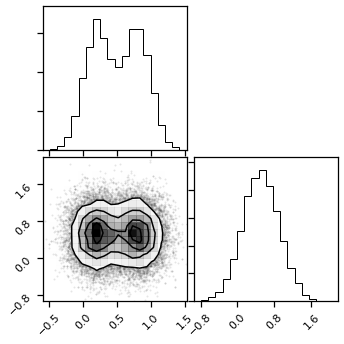

In [287]:

_ = corner.corner(reshaped)

In [288]:
# for n in range(len(initial_state)):
#     plt.hist(samples[:, n], alpha=0.4, density=True)
# x = np.linspace(-9, 9)
# plt.plot(x, dist.prob(x).numpy())

In [290]:
samples, trace = hmc(log_prob, initial_state, num_results, num_burnin)

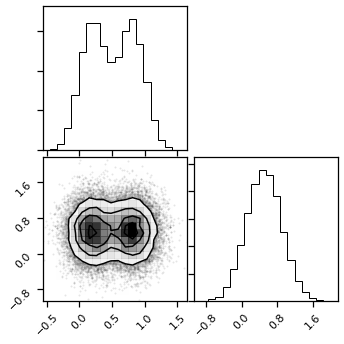

In [292]:
reshaped = samples.numpy().squeeze().reshape(-1, 2)
reshaped.shape
_ = corner.corner(reshaped)